## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].sum()/df['converted'].count()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group']=='treatment') &(df['landing_page']!='new_page'))|((df['group']!='treatment') &(df['landing_page']=='new_page'))].group.count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().user_id.sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df[((df['group']=='treatment') &(df['landing_page']=='new_page'))|((df['group']=='control') &(df['landing_page']!='new_page'))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'], keep=False)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1899 to 2893
Data columns (total 5 columns):
user_id         2 non-null int64
timestamp       2 non-null object
group           2 non-null object
landing_page    2 non-null object
converted       2 non-null int64
dtypes: int64(2), object(3)
memory usage: 96.0+ bytes


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2=df2.drop(df2.index[1899])
df2.user_id.nunique()

290583

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].sum()/df2['converted'].count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[(df2['group']=='control') & (df2['converted']==1)].converted.sum()/df2[df2['group']=='control' ].group.count()

0.12038713319061353

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[(df2['group']=='treatment') & (df2['converted']==1)].converted.sum()/df2[df2['group']=='treatment' ].group.count()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [17]:
df2[(df2['landing_page']=='new_page')].landing_page.count()/df2.landing_page.count()

0.5000653855683727

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Based on the results above, we can summarize the following

 - The probability that a user was in the control group and converted is 0.120 
 - The probability that a user was in treatment group and converted is 0.1188
 
Just looking at the probabilities of conversion in 2 groups, there isnt enough evidence to suggest that new treatment affects the conversion. In fact, the probabilty of users in treatment group converting seems lower than  the control group using the old page. Howevr, given complex nature of these tests and factors such as change aversion further analysis is required to make decisions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

***Null Hypothesis $H_{0}$:*** The existing/old page provides better conversion rates.<br>
***Alternative Hypothesis $H_{1}$:*** The new page provides higher conversion rates than the old page

$H_{0}$:$p_{old}$$\geq$$p_{new}$<br>
$H_{1}$:$p_{old}$<$p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new=df2['converted'].mean()
print(p_new)

0.11959708724499628


Assuming $p_{old}$=$p_{new}$ the convert rate for $p_{new}$ is 0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old=p_new
print(p_old)

0.11959708724499628


Assuming $p_{old}$=$p_{new}$ the convert rate for $p_{old}$ is 0.1196

c. What is $n_{new}$?

In [20]:
n_new=df2[df2['group']=='treatment'].shape[0]
print(n_new)

145311


The sample size of the users receiveing new page is 145311

d. What is $n_{old}$?

In [21]:
n_old=df2[df2['group']=='control'].shape[0]
print(n_old)

145273


The sample size of the users receiveing old page is 145273

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [61]:
#simulate n_new transactions with probability p_new using random.choice function
new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new])
new_page_converted.mean()

0.12095436684077598

I am using Numpy's random.choice function to generate a new set of new page convert rates with the new page sample size

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [60]:
#simulate n_oldtransactions with probability p_old using random.choice function

old_page_converted=np.random.choice([1,0],size=n_old,p=[p_old,1-p_old])
old_page_converted.mean()

0.11974695917341832

I am using Numpy's random.choice function to generate a new set of old page convert rates  with the old page sample size

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
print(np.mean(new_page_converted)-np.mean(old_page_converted))

0.0004299308420393777


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
#Simulate 10000 samples of mean difference in the new and old page conversion probabilities

p_diffs=[]

for i in range(10000):
    new_page_converted=np.random.choice([0,1],size=n_new,p=[p_new,1-p_new]).mean()
    old_page_converted=np.random.choice([0,1],size=n_old,p=[p_old,1-p_old]).mean()
    mean_diffs=new_page_converted-old_page_converted
    p_diffs.append(mean_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  44.,  208.,  922., 2033., 2821., 2322., 1181.,  378.,   79.,
          12.]),
 array([-0.00402964, -0.0031631 , -0.00229657, -0.00143003, -0.00056349,
         0.00030304,  0.00116958,  0.00203611,  0.00290265,  0.00376918,
         0.00463572]),
 <a list of 10 Patch objects>)

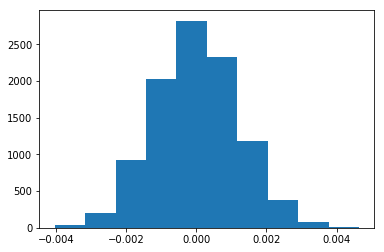

In [26]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [40]:
#re compute the original difference in conversion rate probabilities
orig_p_new=df2[df2['group']=='treatment'].converted.mean()
orig_p_old=df2[df2['group']=='control'].converted.mean()
orig_p_diff=orig_p_new-orig_p_old

#compare actuall difference with the computed p_diffs

p_diffs=np.array(p_diffs)
(p_diffs>orig_p_diff).mean()

0.9056

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

We are comparing the actual convert rate probabity with convert rate probability of the sampling distribution. Statistically, it is called the p-value.The p-value is larger than p-critical(0.05) which is the rejection boundary for an error rate of5%. This indicates that we cannot reject the null in favor of alternative hypothesis. Statistically, the new page doesnt prove to be better than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm;
#compute number of conversions and the size of each group
convert_old = df2[df2['group']=='control'].converted.sum()
convert_new = df2[df2['group']=='treatment'].converted.sum()
n_old = df2[df2['group']=='control'].shape[0]
n_new = df2[df2['group']=='treatment'].shape[0]


C:\Users\send2\Anaconda3\envs\project4\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [63]:
#reference syntax - proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new,convert_old],nobs=[n_new,n_old],alternative='larger')
print(z_score,p_value)

-1.3122916566912053 0.9052891269137592


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Z-scores are measures of standard deviation. the z scores is a test of significance that would allow us to decide whether or not to reject null hypothesis. For a 95% confidence, the critical z- value in a one tailed test is 1.645. Since the z-score computed above (-1.312 )is within this range, we cannot reject the null hypothesis. Similarly the p value corresponds to the error rate in this case 0.05. The computed p-value(0.9052) is higher than 0.05 to be able to not reject the null hypothesis.

Here is a [link](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm) to the source.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# add intercept
df2['intercept']=1
#get dummies for landing page column
df2[['ab_page','ab_page_old']]=pd.get_dummies(df2['landing_page'])


In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,ab_page_old
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [45]:
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Feb 2018   Pseudo R-squ.:               8.094e-06
Time:                        00:14:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1894
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.668      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.189      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

In Part II,<br>
The p-values are associated with the hypothesis that old page conversion rate is "greater" than the new page conversion rate. 

In part III,<br>
The p-values correspond to the two -tailed z-test. This p-value is high enough to not reject hypothesis.<br>
The null hypothesis is $H_{0}$: $p_{old}$-$p_{new}$=0<br>
The alternative hypothesis is $H_{1}$: $p_{old}$-$p_{new}$!=0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider to add more variables to avoid producing biased results and missing out on significant predictors.
Adding a less significant predictors into the model can cause an incorrect estimate and produce a complex model. The adjusted $R^{2}$ value decreases when the added factor doesn't affect the outcomes.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [51]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ab_page_old
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0


In [55]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ab_page_old,CA,UK,US
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [59]:
### Fit Your Linear Model And Obtain the Results
lm=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Feb 2018   Pseudo R-squ.:               2.325e-05
Time:                        00:27:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1757
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.248      0.000      -2.082      -1.978
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.075      -0.005       0.106
==============================================================================
"""

Even with the inclusion of countries, it is not statistically significant to reject null hypothesis. We can conclude that the old page performs better than the new page. The new page doesnt significantly alter the conversion rates.

<a id='conclusions'></a>
## Conclusions
Based on hypothesis testing based on null hypothesis in Part II and logistic regression models fitted in Part III, it can be concluded that the new page did not produce statistically significant outcomes with respect to pge conversion rates.

My suggestions is to accept the null hypothesis and reject the alternative hypothesis.The recommendation for the e-commerce company would be to keep the exiting page.
